In [96]:
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection


def read_split_data(iris_data):
    data = iris_data['data']
    targets = iris_data['target']
    train_data,test_data,train_targets,test_targets = model_selection.train_test_split(data,targets,test_size=0.1)
    return (train_data,test_data,train_targets,test_targets)


iris_dataset = datasets.load_iris()
train_data,test_data,train_targets,test_targets=read_split_data(iris_dataset)


In [97]:
train_targets = tf.keras.utils.to_categorical(train_targets)
test_targets = tf.keras.utils.to_categorical(test_targets)

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(input_shape):
    model = Sequential([
        Dense(64,activation='relu',input_shape=(input_shape),kernel_initializer=tf.keras.initializers.HeUniform(),bias_initializer=tf.keras.initializers.Constant(value=1)),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(3,activation='softmax')
    ])
    return model

In [99]:
model = get_model(train_data[0].shape)

In [100]:
def compile_model(model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.Accuracy()
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

In [101]:
compile_model(model)

In [102]:
def train_model(model,train_data,train_targets,epoch):
    history = model.fit(train_data,train_targets,validation_split=0.15,epochs=epoch,verbose=False)
    return history

In [103]:
history = train_model(model,train_data,train_targets,epoch=800)

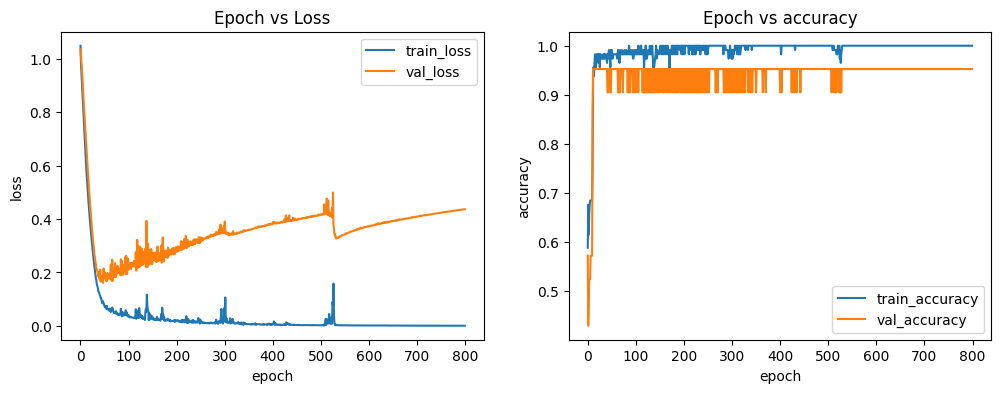

In [104]:
import pandas as pd

def plot_history(history):
    result_df = pd.DataFrame(history.history)
    epoch_arr = np.arange(len(result_df))
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    ax.plot(epoch_arr,result_df['loss'],label="train_loss")
    ax.plot(epoch_arr,result_df['val_loss'],label="val_loss")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_title("Epoch vs Loss")
    ax.legend()


    ax = fig.add_subplot(122)
    ax.plot(epoch_arr,result_df['accuracy'],label="train_accuracy")
    ax.plot(epoch_arr,result_df['val_accuracy'],label="val_accuracy")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.set_title("Epoch vs accuracy")
    ax.legend()

plot_history(history)

In [105]:
def get_regularised_model(input_shape,dropout_rate,weight_decay):
    model = Sequential([
        Dense(64,activation='relu',input_shape=(input_shape),
              kernel_initializer=tf.keras.initializers.HeUniform(),
              bias_initializer=tf.keras.initializers.Constant(value=1),
              kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.Dropout(dropout_rate),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.Dropout(dropout_rate),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.Dropout(dropout_rate),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.Dropout(dropout_rate),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(3,activation='softmax')
    ])
    return model

In [106]:
reg_model = get_regularised_model(train_data[0].shape,0.3,0.001)

In [107]:
compile_model(reg_model)

In [108]:
reg_history = train_model(reg_model,train_data,train_targets, epoch=800)

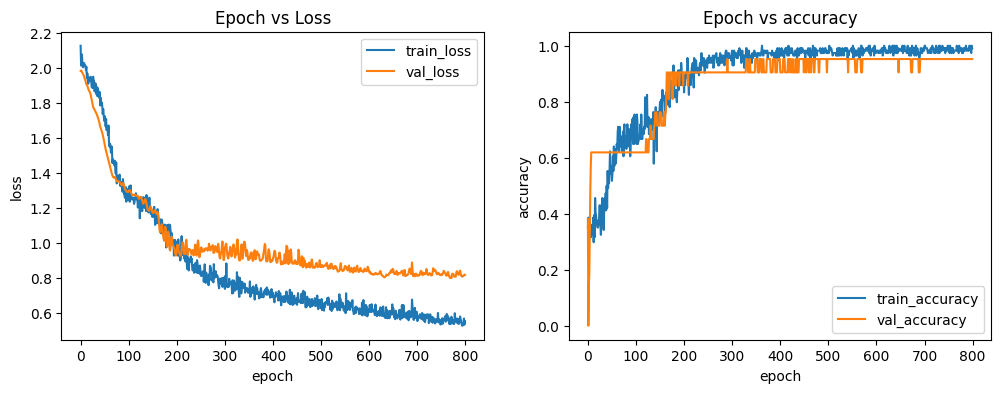

In [109]:
plot_history(reg_history)